In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img , ImageDataGenerator
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D , Dense , Dropout , Flatten


In [19]:
#Fetch images count from folder
dataset_path = '/kaggle/input/flowerrecognition/Flower Recognition/Images'
count = 0
dirs = os.listdir(dataset_path)
for dir in dirs:
    files = list(os.listdir(os.path.join(dataset_path,dir)))
    print(dir + 'Folder has :- '+ str(len(files)) + dataset_path)
    count = count + len(files)
print('Images folder has : '+ str(count) +' Images.')

DandelionsFolder has :- 142/kaggle/input/flowerrecognition/Flower Recognition/Images
DaisyFolder has :- 141/kaggle/input/flowerrecognition/Flower Recognition/Images
SunflowerFolder has :- 137/kaggle/input/flowerrecognition/Flower Recognition/Images
TulipFolder has :- 144/kaggle/input/flowerrecognition/Flower Recognition/Images
RoseFolder has :- 145/kaggle/input/flowerrecognition/Flower Recognition/Images
Images folder has : 709 Images.


Now here all the images are in the form of folders(also in .jpg , .jpeg etc) . So next what we need to do is we need to store them in numpy arrays .


In [20]:
base_dir = '/kaggle/input/flowerrecognition/Flower Recognition/Images'
img_size = 180
batch = 32


In [21]:
# Loading images into arrays as dataset
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,seed =123 , 
                                                       validation_split = 0.2 ,
                                                      subset = 'training',
                                                       batch_size = batch ,
                                                       image_size =(img_size,img_size))
val_ds = tf.keras.utils.image_dataset_from_directory(base_dir,seed =123 , 
                                                       validation_split = 0.2 ,
                                                      subset = 'validation',
                                                       batch_size = batch ,
                                                       image_size =(img_size,img_size))

Found 607 files belonging to 5 classes.
Using 486 files for training.
Found 607 files belonging to 5 classes.
Using 121 files for validation.


In [22]:
flower_names = train_ds.class_names
flower_names

['Daisy', 'Dandelions', 'Rose', 'Sunflower', 'Tulip']

This are going to be class names for training dataset

In [23]:
import matplotlib.pyplot as plt

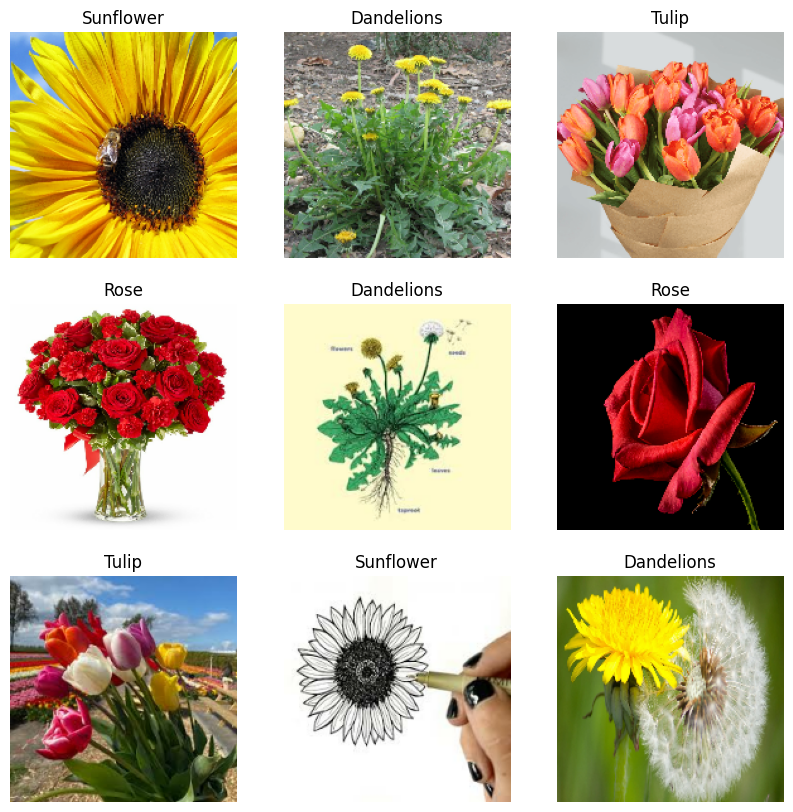

In [25]:
i = 0
plt.figure(figsize = (10,10))

for images,labels in train_ds.take(1):
    for i in range(9): 
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')        

In [26]:
AUTOTUNE = tf.data.AUTOTUNE


In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [29]:
val_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [54]:
# Data Augmentation
from tensorflow.keras import layers
img_size = 180
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal",input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
print("Data augmentation layer defined successfully!")


Data augmentation layer defined successfully!


In [55]:
i = 0
plt.figure(figsize = (10,10))

for images,labels in train_ds.take(1):
    for i in range(9): 
        images = data_augmentation(images)
        plt.subplot(3,3,i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')      

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

<Figure size 1000x1000 with 0 Axes>

In [45]:
import os
from PIL import Image

directory = '/kaggle/input/flowerrecognition/Flower Recognition/Images'

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that the file is an image
        return True
    except:
        return False

for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        if not is_valid_image(file_path):
            print(f"Invalid image file removed: {file_path}")
            os.remove(file_path)  # Be cautious when using this!


Invalid image file removed: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector4.svg


OSError: [Errno 30] Read-only file system: '/kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector4.svg'

In [46]:
import tensorflow as tf
import os
from PIL import Image

directory = '/kaggle/input/flowerrecognition/Flower Recognition/Images'
valid_images = []

# Check for valid images
for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if it's a valid image
                valid_images.append(file_path)  # Add valid images to the list
        except:
            print(f"Skipping invalid file: {file_path}")

print(f"Found {len(valid_images)} valid image files.")

# Dynamically create a dataset from valid images
valid_image_ds = tf.data.Dataset.from_tensor_slices(valid_images)


Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector4.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector3.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector7.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector9.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector13.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector14.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector10.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector5.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector6.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower

In [47]:
import os
from shutil import copy2
from PIL import Image

source_dir = '/kaggle/input/flowerrecognition/Flower Recognition/Images'
target_dir = '/kaggle/working/cleaned_images'

os.makedirs(target_dir, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        source_path = os.path.join(root, file)
        target_path = os.path.join(target_dir, file)
        try:
            with Image.open(source_path) as img:
                img.verify()  # Verify if it's a valid image
                copy2(source_path, target_path)  # Copy valid files
        except:
            print(f"Skipping invalid file: {source_path}")

print("Cleaned image dataset copied to:", target_dir)


Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector4.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector3.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector7.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector9.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector13.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector14.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector10.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector5.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector6.svg
Skipping invalid file: /kaggle/input/flowerrecognition/Flower

In [53]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/cleaned_images',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=32
)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory /kaggle/working/cleaned_images. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [49]:
import os

source_dir = '/kaggle/input/flowerrecognition/Flower Recognition/Images'
valid_formats = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

valid_images = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_formats)]
print(f"Found {len(valid_images)} valid image files in source directory.")


Found 0 valid image files in source directory.


In [50]:
target_dir = '/kaggle/working/cleaned_images'

if not os.path.exists(target_dir):
    print("Target directory does not exist!")
else:
    valid_files = [f for f in os.listdir(target_dir) if f.lower().endswith(valid_formats)]
    print(f"Found {len(valid_files)} valid image files in target directory.")


Found 456 valid image files in target directory.


In [51]:
from shutil import copy2
from PIL import Image

os.makedirs(target_dir, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        source_path = os.path.join(root, file)
        if file.lower().endswith(valid_formats):  # Skip unsupported formats
            try:
                with Image.open(source_path) as img:
                    img.verify()  # Ensure it's a valid image
                    copy2(source_path, target_dir)
            except:
                print(f"Skipping invalid or corrupted image: {source_path}")
        else:
            print(f"Skipping unsupported file: {source_path}")


Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector4.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/Dandelion-1.jpg.webp
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector3.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector7.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector9.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector13.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector14.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector10.svg
Skipping unsupported file: /kaggle/input/flowerrecognition/Flower Recognition/Images/Dandelions/vector5.svg
Skipping unsuppo